## About project

### Objective

```quote
This project aims to segment customers based on their purchasing behavior using Recency, Frequency, and Monetary (RFM) analysis combined with K-Means clustering. The goal is to identify different customer groups to improve targeted marketing strategies and enhance customer relationship management (CRM).
```

![Cover](cover.png)
### Methodology
1. Exploratory Data Analysis (EDA)
- Clean and preprocess the dataset by handling missing values and duplicate records.
- Identify key entities and metrics, such as InvoiceNo, CustomerID, StockCode, InvoiceDate, Quantity, and UnitPrice.
- Analyze transaction patterns, including order cancellations and their impact on revenue.
2. RFM Analysis
- Recency (R): Number of days since the customer's last purchase.
- Frequency (F): Total number of purchases made by the customer.
- Monetary (M): Total amount spent by the customer.<br>
<b>Calculate RFM scores and visualize their distributions.</b>
3. Customer Segmentation Using K-Means Clustering
- Normalize the RFM values to ensure equal weighting.
- Apply Elbow Method and Silhouette Score to determine the optimal number of clusters.
- Perform K-Means clustering and assign customers to different groups.
- Interpret each cluster's characteristics and business implications.
4. Business Insights & Recommendations
- Identify high-value customers (VIPs) and potential churners.
- Develop personalized marketing strategies based on customer segments.
- Recommend actions to retain valuable customers and re-engage inactive ones.
### Expected Outcomes
- A well-defined customer segmentation model.
- Insights into customer behavior to improve retention and engagement.
- Actionable strategies for CRM optimization and revenue growth.
### Reference
Customer Segmentation on Kaggle: [Fabien Daniel's Notebook](https://www.kaggle.com/code/fabiendaniel/customer-segmentation/notebook#1.-Data-preparation)

## Import Packages

In [50]:
import warnings 
warnings.filterwarnings('ignore')

In [51]:
import pandas as pd
import openpyxl
import numpy as np
import datetime as dt

import scipy
import os
import seaborn as sns
import matplotlib.pyplot as plt

import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from IPython.display import display, HTML

%matplotlib inline

In [52]:
from scipy import stats
from scipy.stats import chi2_contingency
from scipy.stats import chi2

In [53]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import silhouette_samples

### Setting

In [54]:
## Theme
colorscale1 = ['#A9B5DF', '#7886C7', '#2D336B']
    

## About dataset

In [55]:
## Upload the dataset
df_ogr= pd.read_csv( r'dataset/data/data.csv', encoding= 'ISO-8859-1')
df_ogr.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [56]:
## Build Function: tab_info:
def tab_info(data):
    tab_info = pd.concat([
    pd.DataFrame(data.dtypes, columns=['column type']).T,
    pd.DataFrame(data.notnull().sum(), columns=['non-null count']).T,
    pd.DataFrame(data.isnull().sum(), columns=['null values (nb)']).T,
    pd.DataFrame(data.isnull().sum() / data.shape[0] * 100, columns=['null values (%)']).T
    ])
    return tab_info

In [57]:
display(tab_info(df_ogr))

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
column type,object,object,object,int64,object,float64,float64,object
non-null count,541909,541909,540455,541909,541909,541909,406829,541909
null values (nb),0,0,1454,0,0,0,135080,0
null values (%),0.0,0.0,0.268311,0.0,0.0,0.0,24.926694,0.0


### Evaluation:
- Why **InvoiceNo** datatype is object?
- **InvoiceDate** is not correct dtypes -> Converting into timestamp<br>
- **Description** is missing may be casue by not recorded
- **CustomerID** with approximately 25% null data:<br>
Unlessly this case not impute so delete whole records are null at **CustomerID**

In [58]:
# Explore the feature InvocieNO
df_ogr[df_ogr.InvoiceNo.astype(str).str.contains(r'\D', regex=True, na=False)].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,12/1/2010 9:41,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,12/1/2010 9:49,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,12/1/2010 10:24,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548.0,United Kingdom


The Invoice with invoiceno have the first character 'C' is attrached with the quantity < 0<br> 
-> This may be whole the cancelled orders

In [59]:
print('The number and proportion of duplicated records')
display(df_ogr.duplicated().sum(), df_ogr.duplicated().sum()*100/ df_ogr.shape[0])

The number and proportion of duplicated records


5268

0.9721189350979592

Remove duplicated records and keep= 'first'

## Data Preparation

In [60]:
df_ogr['InvoiceDate']= pd.to_datetime(df_ogr['InvoiceDate'])
df_ogr['CustomerID'] = df_ogr['CustomerID'].astype('object')
tab_info(df_ogr)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
column type,object,object,object,int64,datetime64[ns],float64,object,object
non-null count,541909,541909,540455,541909,541909,541909,406829,541909
null values (nb),0,0,1454,0,0,0,135080,0
null values (%),0.0,0.0,0.268311,0.0,0.0,0.0,24.926694,0.0


In [61]:
df= df_ogr.copy()

In [62]:
tab_info(df)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
column type,object,object,object,int64,datetime64[ns],float64,object,object
non-null count,541909,541909,540455,541909,541909,541909,406829,541909
null values (nb),0,0,1454,0,0,0,135080,0
null values (%),0.0,0.0,0.268311,0.0,0.0,0.0,24.926694,0.0


### Cleaning Dataset

In [63]:
## Remove all row with missing value at col CustomerID
df.dropna(axis = 0, subset = ['CustomerID'], inplace = True)

In [64]:
## Remove duplicated records
df.drop_duplicates(inplace= True, keep= 'first')

In [65]:
display(df.shape, df.head(), tab_info(df), print('The number of duplicated record'), df.duplicated().sum())

The number of duplicated record


(401604, 8)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
column type,object,object,object,int64,datetime64[ns],float64,object,object
non-null count,401604,401604,401604,401604,401604,401604,401604,401604
null values (nb),0,0,0,0,0,0,0,0
null values (%),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


None

0

In [66]:
display(df.describe(), df.describe(include='object'))

,Quantity,InvoiceDate,UnitPrice
count,401604.000000,401604,401604.000000
mean,12.183273,2011-07-10 12:08:23.848567552,3.474064
min,-80995.000000,2010-12-01 08:26:00,0.000000
25%,2.000000,2011-04-06 15:02:00,1.250000
50%,5.000000,2011-07-29 15:40:00,1.950000
75%,12.000000,2011-10-20 11:58:30,3.750000
max,80995.000000,2011-12-09 12:50:00,38970.000000
std,250.283037,NaN,69.764035


,InvoiceNo,StockCode,Description,CustomerID,Country
count,401604,401604,401604,401604.0,401604
unique,22190,3684,3896,4372.0,37
top,576339,85123A,WHITE HANGING HEART T-LIGHT HOLDER,17841.0,United Kingdom
freq,542,2065,2058,7812.0,356728


## Explore Data Analysis_EDA

```mermaid
graph LR
    subgraph "Class 1"
        Country
    end
    subgraph "Class 2"
        subgraph "Entities"
            Customer & Product
        end
    end
    subgraph "Class 3"
        Invoice["Transaction / Invoice"]
    end

    Country -->|Has| Customer
    Country -->|Sells| Product
    Entities --> |Creates| Invoice

    style Country fill:#ff6666,stroke:#ff3333,stroke-width:2px,color:#ffffff
    style Entities fill:#33cc33,stroke:#009900,stroke-width:2px,color:#ffffff
    style Invoice fill:#6666ff,stroke:#3333cc,stroke-width:2px,color:#ffffff
    style Customer fill:#33cc33,stroke:#009900,stroke-width:2px,color:#ffffff
    style Product fill:#33cc33,stroke:#009900,stroke-width:2px,color:#ffffff
```

### Comparison of Class 1 with Class 2 and Class 3

In [67]:
temp = df[['CustomerID', 'InvoiceNo', 'Country']].groupby(['CustomerID', 'InvoiceNo', 'Country']).count()
temp = temp.reset_index(drop = False)

countries = temp['Country'].value_counts()
print('Number of countries in dataset: {}'.format(len(countries)))

Number of countries in dataset: 37


In [68]:
df[['CustomerID', 'InvoiceNo', 'Country']].head()

,CustomerID,InvoiceNo,Country
0,17850.0,536365,United Kingdom
1,17850.0,536365,United Kingdom
2,17850.0,536365,United Kingdom
3,17850.0,536365,United Kingdom
4,17850.0,536365,United Kingdom


In [69]:
display(temp.head(), countries[:5])

,CustomerID,InvoiceNo,Country
0,12346.0,541431,United Kingdom
1,12346.0,C541433,United Kingdom
2,12347.0,537626,Iceland
3,12347.0,542237,Iceland
4,12347.0,549222,Iceland


Country
United Kingdom    19857
Germany             603
France              458
EIRE                319
Belgium             119
Name: count, dtype: int64

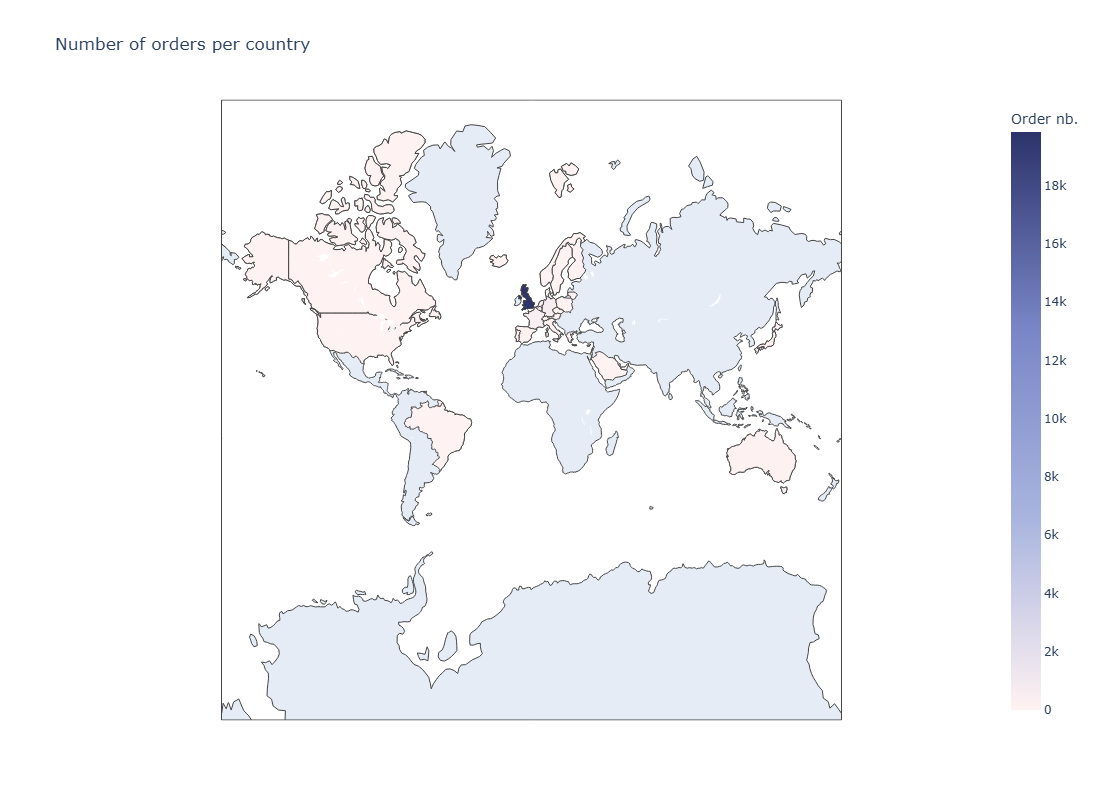

In [98]:
# Enable Plotly to work offline in Jupyter Notebook
init_notebook_mode(connected=True)

# Define the choropleth map data
data = dict(
    ## Setting main board
    type= 'choropleth',  # Specifies the type of visualization (choropleth map)
    locations= countries.index,  # Country names (index of the 'countries' Series)
    locationmode= 'country names',  # Mode to match locations by country names
    z= countries,  # Data values corresponding to each country
    text= countries.index,  # Hover text (country names)

    ## Ensure colorbar is correctly defined
    colorbar = {'title':'Order nb.'},

    ## Change the color scale to Viridis
    colorscale = [
    [0, '#FFF2F2'],
    [0.33, '#A9B5DF'],  
    [0.66, '#7886C7'],  
    [1, '#2D336B']  
    ],
    reversescale = False
)
# Define the layout (appearance) of the map with increased size
layout = dict(
    title='Number of orders per country',  # Title of the map
    geo = dict(showframe = True, projection={'type':'mercator'}),
    width=900,  # Set width to 1200 pixels
    height=800   # Set height to 800 pixels
)

# Create the figure with data and layout
choromap = go.Figure(data=[data], layout=layout)

# Display the choropleth map
iplot(choromap, validate=False)


The dataset is largely dominated by the UK, with nearly 24,000 orders.<br> This analysis includes both canceled and completed transactions.

## Comparison of Class 2 with Class 3

In [71]:
# Total the number of transaction from each customers
customer_orders = df.groupby('CustomerID')['InvoiceNo'].nunique()

# Avg the number of products by each transaction
avg_items_per_order = df.groupby('InvoiceNo')['Quantity'].sum().mean()

print(f"Avg of orders by each customers: {customer_orders.mean():.2f}")
print(f"Avg of items by each customers: {avg_items_per_order:.2f}")


Avg of orders by each customers: 5.08
Avg of items by each customers: 220.50


In [72]:
df_1 = {
    'customers': len(df.CustomerID.value_counts()),
    'products': len(df.StockCode.value_counts()),
    'transactions': len(df.InvoiceNo.value_counts())
}
pd.DataFrame([df_1], index=['quantity'])


,customers,products,transactions
quantity,4372,3684,22190


**Next Step**: Precisely Identify Transactions<br>
Since the initial analysis reveals multiple types of invoices<br>
We will handle this by grouping CustomerID and InvoiceNo, then counting the number of products in each transaction for each days.

In [73]:
temp = df.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate'].count()
temp= temp.rename(columns = {'InvoiceDate':'Number of products'})
temp[:10].sort_values('CustomerID')

,CustomerID,InvoiceNo,Number of products
0,12346.0,541431,1
1,12346.0,C541433,1
2,12347.0,537626,31
3,12347.0,542237,29
4,12347.0,549222,24
5,12347.0,556201,18
6,12347.0,562032,22
7,12347.0,573511,47
8,12347.0,581180,11
9,12348.0,539318,17


- the existence of entries with the prefix C for the InvoiceNo variable: this indicates transactions that have been canceled
- the existence of users who only came once and only purchased one product (e.g. <b>CustoemrID</b>= 12346)
- the existence of frequent users that buy a large number of items at each order


In [74]:
temp['order_canceled'] = temp['InvoiceNo'].apply(lambda x:int('C' in x))
display(temp[:5])

n1 = temp['order_canceled'].sum()
n2 = temp.shape[0]
print(f'The proportion of cancelled orders: {(n1 * 100 / n2):.2f}%')

,CustomerID,InvoiceNo,Number of products,order_canceled
0,12346.0,541431,1,0
1,12346.0,C541433,1,1
2,12347.0,537626,31,0
3,12347.0,542237,29,0
4,12347.0,549222,24,0


The proportion of cancelled orders: 16.47%


**After exploring the canceled orders**, we can clearly see that other transactions in the dataset are mostly identical, except for the **Quantity and InvoiceDate variables**.<br>

To verify if this pattern holds for all entries, we will identify transactions with negative quantities and check whether there is always a corresponding order with the same quantity (but positive), along with **the same CustomerID, Description, and UnitPrice.**

In [75]:
df_check = df[df['Quantity'] < 0][['CustomerID','Quantity',
                                   'StockCode','Description','UnitPrice']]
for index, col in  df_check.iterrows():
    if df[
    (df['CustomerID'] == col[0]) 
    & (df['Quantity'] == -col[1]) 
    & (df['Description'] == col[2])
    ].shape[0] == 0: 
        print(df_check.loc[index])
        print(15*'-'+'>'+' HYPOTHESIS NOT FULFILLED')
        break

CustomerID      14527.0
Quantity             -1
StockCode             D
Description    Discount
UnitPrice          27.5
Name: 141, dtype: object
---------------> HYPOTHESIS NOT FULFILLED



<b>The hypothesis is not fulfilled</b> when the description is "discount."

We decide to investigate further by analyzing the entries while<b> excluding those labeled as "discount."</b>

In [76]:
df_check = df[(df['Quantity'] < 0) & (df['Description'] != 'Discount')][['CustomerID','Quantity',
                                                   'StockCode','Description','UnitPrice']]
for index, col in  df_check.iterrows():
    if df[(df['CustomerID'] == col[0]) 
    & (df['Quantity'] == -col[1]) 
    & (df['Description'] == col[2])].shape[0] == 0: 
        print(df_check.loc[index])
        print(15*'-'+'>'+' HYPOTHESIS NOT FULFILLED')
        break

CustomerID                             15311.0
Quantity                                    -1
StockCode                               35004C
Description    SET OF 3 COLOURED  FLYING DUCKS
UnitPrice                                 4.65
Name: 154, dtype: object
---------------> HYPOTHESIS NOT FULFILLED


Once again, we find that the **initial hypothesis is not confirmed**, meaning cancellations do not always correspond to previously placed orders.<br>

At this stage, I decide to create a new variable in the dataframe to indicate whether part of the order has been canceled. For cancellations without a corresponding order, some may be due to purchases made before December 2010, which marks the starting point of the dataset.

Below, I analyze the canceled orders and check for the existence of matching counterparts.



**Step 1:** Initialize Data  
- Copy `df` to `df_2` and create a new column `QuantityCancelled`, setting all values to `0`.  
- Create two lists:  
  - `entry_remove`: Stores indices of matched canceled transactions.  
  - `counterpart`: Stores indices of unmatched canceled transactions.  

**Step 2:** Create `merged_df` with Counterpart Matching  
- **Filter canceled transactions** by creating `cancel_orders` (negative quantity), adding `index_cancel`.  
- **Filter valid transactions** (positive quantity), adding `index_valid`.  
- **Merge canceled orders** with valid orders based on `CustomerID`, `StockCode`, and `Description`.  
- Keep only records where the **valid order** happened before the **cancellation** (`InvoiceDate_valid < InvoiceDate_cancel`).  

**Step 3:** Handle Cancellation Cases  
**Case 1: No Matching Counterpart**  
    - Identify canceled orders that do not exist in `merged_df`.  
    - Append their indices to `counterpart`.  

**Case 2: Exactly One Counterpart Found**  
    - Identify rows where a canceled order has a unique matching valid order.  
    - Update `QuantityCancelled` in `df_2` for the valid order.  
    - Append the canceled order’s index to `entry_remove`.  

**Case 3: Multiple Counterparts Found**  
    - Use `.nlargest(1, "InvoiceDate_valid")` to select the most recent valid order.  
    - Update `QuantityCancelled` in `df_2`.  
    - Append the canceled order’s index to `entry_remove`.  

**Step 4:** Finalizing Data  
- Remove matched cancellations from `df_2` based on `entry_remove`.  
- The final output includes:  
  - **`df_2`**: Updated dataset with `QuantityCancelled` values.  
  - **`counterpart`**: List of unmatched cancellations.  
  - **`entry_remove`**: List of removed (matched) cancellations.  


In [77]:
df_2 = df.copy(deep=True)
df_2["QuantityCanceled"] = 0  # Initialize a new column to track canceled quantities

# Create lists for tracking removed and unmatched entries
entry_remove = []; doubt_entry = []

# Filter canceled transactions (negative quantity)
cancel_orders = df[df["Quantity"] < 0].copy()
cancel_orders["index_cancel"] = cancel_orders.index  # Preserve original index

# Filter valid transactions (positive quantity)
valid_orders = df[df["Quantity"] > 0].copy()
valid_orders["index_valid"] = valid_orders.index  # Preserve original index

# Merge canceled orders with valid orders based on CustomerID, StockCode, and Description
merged_df = cancel_orders.merge(
    valid_orders,
    on=["CustomerID", "StockCode", "Description"],
    suffixes=("_cancel", "_valid")
)

# Keep only records where the valid order happened before the cancellation
merged_df = merged_df[merged_df["InvoiceDate_valid"] < merged_df["InvoiceDate_cancel"]]

# Case 1: No matching counterpart found
no_match = cancel_orders.loc[~cancel_orders["index_cancel"].isin(merged_df["index_cancel"])]
entry_remove.extend(no_match["index_cancel"].tolist())  # Store indices of unmatched cancellations

# Case 2: Exactly one counterpart found
single_match = merged_df.groupby("index_cancel").filter(lambda x: len(x) == 1)
df_2.loc[single_match["index_valid"], "QuantityCanceled"] = -single_match["Quantity_cancel"].values
doubt_entry.extend(single_match["index_cancel"].tolist())  # Store indices of matched cancellations

# Case 3: Multiple counterparts found - Select the latest one based on InvoiceDate
multiple_match = merged_df.groupby("index_cancel").apply(lambda x: x.nlargest(1, "InvoiceDate_valid"))
df_2.loc[multiple_match["index_valid"], "QuantityCanceled"] = -multiple_match["Quantity_cancel"].values
doubt_entry.extend(multiple_match["index_cancel"].tolist())  # Store indices of matched cancellations


In [78]:
display(merged_df.head(), pd.DataFrame({'entry_remove': [len(entry_remove)], 'doubt_entry': [len(doubt_entry)]}, index= ['count']))


,InvoiceNo_cancel,StockCode,Description,Quantity_cancel,InvoiceDate_cancel,UnitPrice_cancel,CustomerID,Country_cancel,index_cancel,InvoiceNo_valid,Quantity_valid,InvoiceDate_valid,UnitPrice_valid,Country_valid,index_valid
4,C536506,22960,JAM MAKING SET WITH JARS,-6,2010-12-01 12:38:00,4.25,17897.0,United Kingdom,939,536488,8,2010-12-01 12:31:00,4.25,United Kingdom,884
79,C536737,22798,ANTIQUE GLASS DRESSING TABLE POT,-2,2010-12-02 13:05:00,2.95,15922.0,United Kingdom,3919,536537,8,2010-12-01 13:51:00,2.95,United Kingdom,1342
80,C536758,21314,SMALL GLASS HEART TRINKET POT,-1,2010-12-02 14:25:00,2.10,13767.0,United Kingdom,4288,536395,8,2010-12-01 10:47:00,2.10,United Kingdom,270
111,C536826,35004B,SET OF 3 BLACK FLYING DUCKS,-2,2010-12-02 17:30:00,4.65,17924.0,United Kingdom,4939,536397,12,2010-12-01 10:51:00,4.65,United Kingdom,296
114,C536826,35004B,SET OF 3 BLACK FLYING DUCKS,-3,2010-12-02 17:30:00,4.65,17924.0,United Kingdom,4940,536397,12,2010-12-01 10:51:00,4.65,United Kingdom,296


,entry_remove,doubt_entry
count,1371,12292


In [79]:
type(df_2)

pandas.core.frame.DataFrame

In [80]:
df_2.drop(entry_remove, axis= 0, inplace= True)
tab_info(df_2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled
column type,object,object,object,int64,datetime64[ns],float64,object,object,int64
non-null count,400233,400233,400233,400233,400233,400233,400233,400233,400233
null values (nb),0,0,0,0,0,0,0,0,0
null values (%),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [81]:
# Determine the canceled transactions
df_2["IsCanceled"] = df_2["InvoiceNo"].astype(str).str.startswith("C")

# Handling QuantityCancelled by IsCancelled
df_2.loc[df_2["IsCanceled"], "QuantityCanceled"] = df_2["Quantity"]

# Remove prefix 'C" for fit with counterpart
df_2["InvoiceNo_clean"] = df_2["InvoiceNo"].astype(str).str.replace("^C", "", regex=True)

# Create `TotalPrice`
df_2["TotalPrice"] = (df_2["Quantity"] - df_2["QuantityCanceled"]) * df_2["UnitPrice"]

# Sort CustomerID, InvoiceDate 
df_2 = df_2.sort_values(["CustomerID", "InvoiceDate"]).reset_index(drop=True)

df_2.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled,IsCanceled,InvoiceNo_clean,TotalPrice
0,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346.0,United Kingdom,74215,False,541431,0.0
1,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,2011-01-18 10:17:00,1.04,12346.0,United Kingdom,-74215,True,541433,0.0
2,537626,85116,BLACK CANDELABRA T-LIGHT HOLDER,12,2010-12-07 14:57:00,2.10,12347.0,Iceland,0,False,537626,25.2
3,537626,22375,AIRLINE BAG VINTAGE JET SET BROWN,4,2010-12-07 14:57:00,4.25,12347.0,Iceland,0,False,537626,17.0
4,537626,71477,COLOUR GLASS. STAR T-LIGHT HOLDER,12,2010-12-07 14:57:00,3.25,12347.0,Iceland,0,False,537626,39.0


## StockCode

In [82]:
list_special_codes = df_2[df_2['StockCode'].str.contains('^[a-zA-Z]+', regex=True)]['StockCode'].unique()
list_special_codes

array(['POST', 'M', 'C2', 'BANK CHARGES', 'PADS', 'DOT'], dtype=object)

In [83]:
for code in list_special_codes:
    print("{:<15} -> {:<30}".format(code, df_2[df_2['StockCode'] == code]['Description'].unique()[0]))

POST            -> POSTAGE                       
M               -> Manual                        
C2              -> CARRIAGE                      
BANK CHARGES    -> Bank Charges                  
PADS            -> PADS TO MATCH ALL CUSHIONS    
DOT             -> DOTCOM POSTAGE                


In [84]:
# StockCode Category
df_2['StockCode_Type'] = df_2['StockCode'].apply(lambda x: x if pd.Series(x).str.contains('^[a-zA-Z]+', regex=True).any() else 'Regular')

# Kiểm tra kết quả
df_2[['StockCode', 'StockCode_Type']].drop_duplicates().head()


,StockCode,StockCode_Type
0,23166,Regular
2,85116,Regular
3,22375,Regular
4,71477,Regular
5,22492,Regular


In [85]:
df_2.StockCode_Type.value_counts()

StockCode_Type
Regular         398593
POST              1139
M                  335
C2                 134
DOT                 16
BANK CHARGES        12
PADS                 4
Name: count, dtype: int64

## Using ML for clusterring
In this case I will not remove the situations which are counterpart 

In [86]:
# Identifying the date
analysis_date = df_2['InvoiceDate'].max() + dt.timedelta(days=1)

# Calucating Recency, Frequency, Monetary for each customers
rfm = df_2.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (analysis_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',  # Frequency
    'UnitPrice': lambda x: (x * df_2.loc[x.index, 'Quantity']).sum()  # Monetary
})
# Rename
rfm.columns = ['Recency', 'Frequency', 'Monetary']

# Check
rfm.head()


,Recency,Frequency,Monetary
CustomerID,,,
12346.0,326,2,0.00
12347.0,2,7,4310.00
12348.0,75,4,1797.24
12349.0,19,1,1757.55
12350.0,310,1,334.40


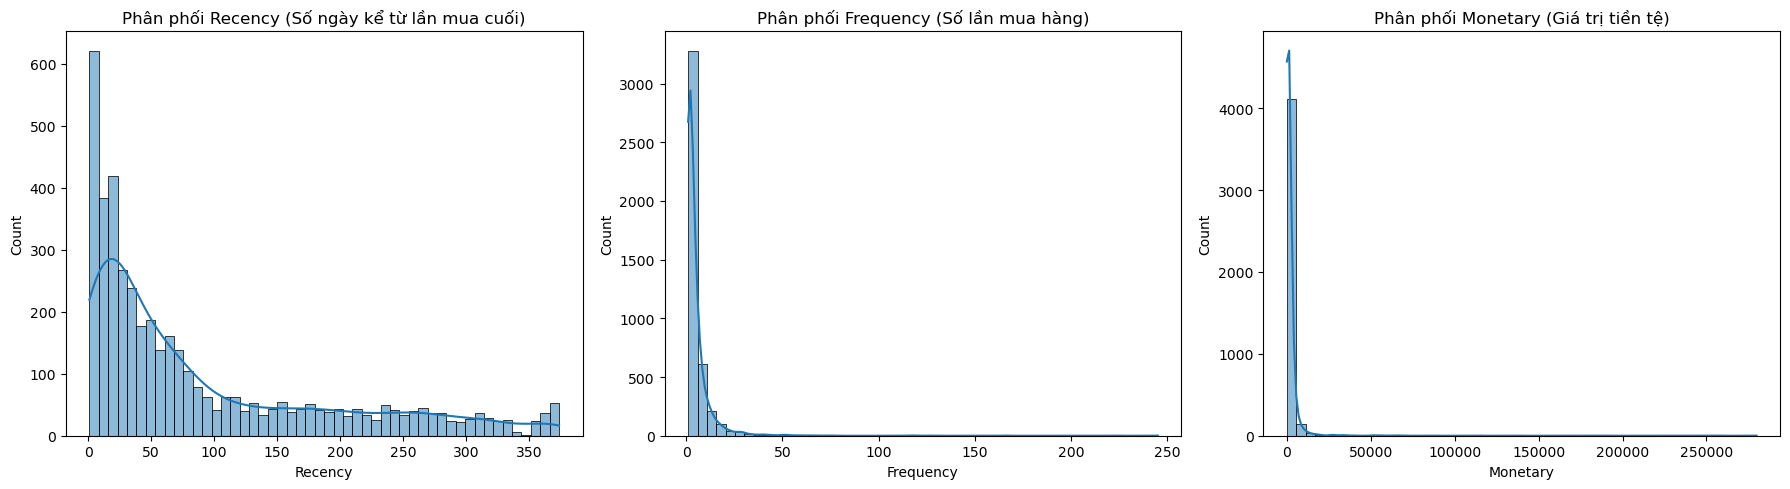

In [87]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Distribution Recency
sns.histplot(rfm['Recency'], bins=50, kde=True, ax=axes[0])
axes[0].set_title('Phân phối Recency (Số ngày kể từ lần mua cuối)')

# Distribution Frequency
sns.histplot(rfm['Frequency'], bins=50, kde=True, ax=axes[1])
axes[1].set_title('Phân phối Frequency (Số lần mua hàng)')

# Distribution Monetary
sns.histplot(rfm['Monetary'], bins=50, kde=True, ax=axes[2])
axes[2].set_title('Phân phối Monetary (Giá trị tiền tệ)')

plt.tight_layout()
plt.show()


In [88]:
# StandardScaler RFM
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)

# Apply  K-Means =4
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

# Display
rfm.groupby('Cluster').mean()


,Recency,Frequency,Monetary
Cluster,,,
0,42.538411,4.247140,1316.475251
1,246.362524,1.803202,489.837138
2,7.916667,104.666667,120445.421667
3,11.354369,26.737864,11708.737913


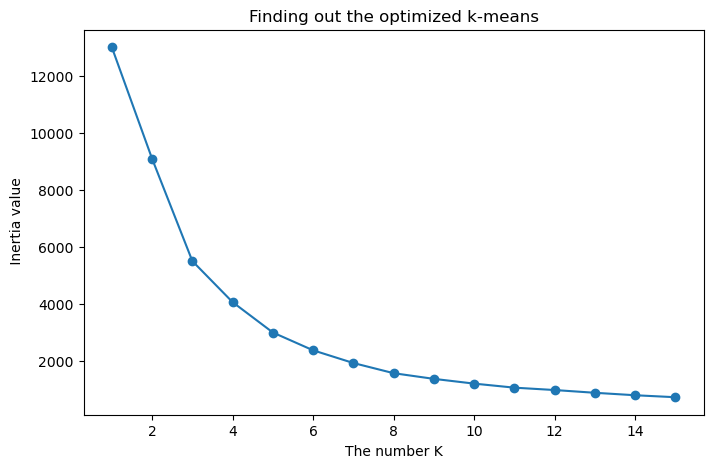

In [89]:
inertia = []
K_range = range(1, 16)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(rfm_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8,5))
plt.plot(K_range, inertia, marker='o')
plt.xlabel('The number K')
plt.ylabel(' Inertia value')
plt.title('Finding out the optimized k-means')
plt.show()


Bias the plotting I choose the k-mean= 5 this is better to retrieve the optimized insight

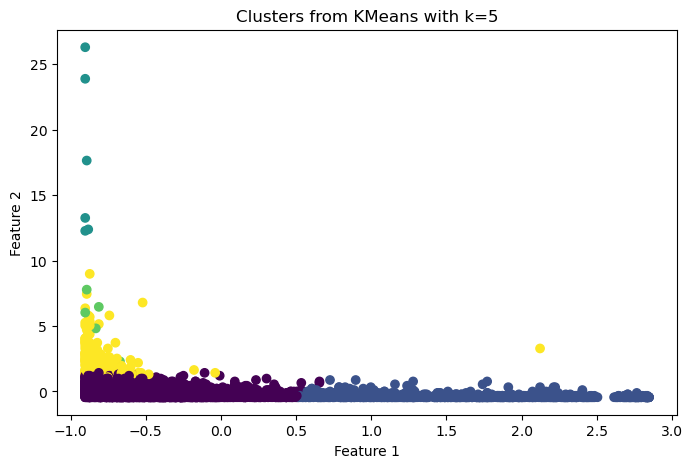

In [90]:
# Fit the model with k=5
kmeans_optimized = KMeans(n_clusters=5, random_state=42, n_init=10)
kmeans_optimized.fit(rfm_scaled)

# Predict cluster labels for each data point
labels = kmeans_optimized.labels_

# Add the labels to your original DataFrame
# Chắc chắn labels là một mảng đúng kích thước
rfm_scaled = pd.DataFrame(rfm_scaled)

# Put cluster labels
rfm_scaled['Cluster'] = pd.Series(labels)


# Optional: View the cluster centers
cluster_centers = kmeans_optimized.cluster_centers_

# Optional: Visualize the clusters (if you want to plot a 2D or 3D visualization)
# Example of 2D plot using the first two principal components (if you performed PCA before)
plt.figure(figsize=(8, 5))
plt.scatter(rfm_scaled.iloc[:, 0], rfm_scaled.iloc[:, 1], c=labels, cmap='viridis')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Clusters from KMeans with k=5')
plt.show()


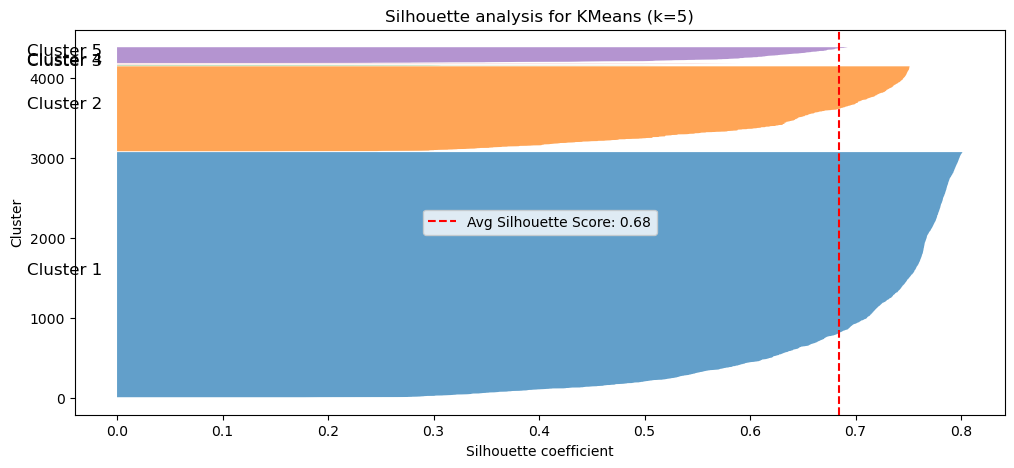

In [96]:
# Assume `rfm_scaled` is the normalized data and `labels` are the cluster labels from KMeans
sample_silhouette_values = silhouette_samples(rfm_scaled, labels)

# Define number of clusters
n_clusters = 5  # Example: 5 clusters

# Create the plot figure
fig, ax = plt.subplots(figsize=(12, 5))

# Initialize the starting point for plotting each cluster's silhouette scores
y_lower = 10

# Loop through each cluster
for i in range(n_clusters):
    # Get silhouette scores for the current cluster
    cluster_silhouette_values = sample_silhouette_values[labels == i]
    
    # Sort silhouette scores for the current cluster
    cluster_silhouette_values.sort()
    
    # Determine the height for the current cluster
    size_cluster = cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster
    
    # Plot the silhouette scores for the current cluster
    ax.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_silhouette_values, alpha=0.7)
    
    # Add the cluster label on the plot
    ax.text(-0.05, (y_lower + y_upper) / 2, f"Cluster {i+1}", fontsize=12, ha="center")
    
    # Update y_lower for the next cluster
    y_lower = y_upper + 10

# Plot the average silhouette score as a red vertical line
avg_silhouette = np.mean(sample_silhouette_values)
ax.axvline(x=avg_silhouette, color="red", linestyle="--", label=f'Avg Silhouette Score: {avg_silhouette:.2f}')

# Customize the plot with labels, title, and legend
ax.set_xlabel("Silhouette coefficient")
ax.set_ylabel("Cluster")
ax.set_title(f"Silhouette analysis for KMeans (k={n_clusters})")
ax.legend()

# Display the plot
plt.show()


In [92]:
# Create churn feature( R_value>180 days)
rfm['Churn'] = (rfm['Recency'] > 180).astype(int)

# Split train/test set
X = rfm[['Recency', 'Frequency', 'Monetary']]
y = rfm['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Traing RandomForest model
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Evaluated metric
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       707
           1       1.00      0.99      1.00       161

    accuracy                           1.00       868
   macro avg       1.00      1.00      1.00       868
weighted avg       1.00      1.00      1.00       868



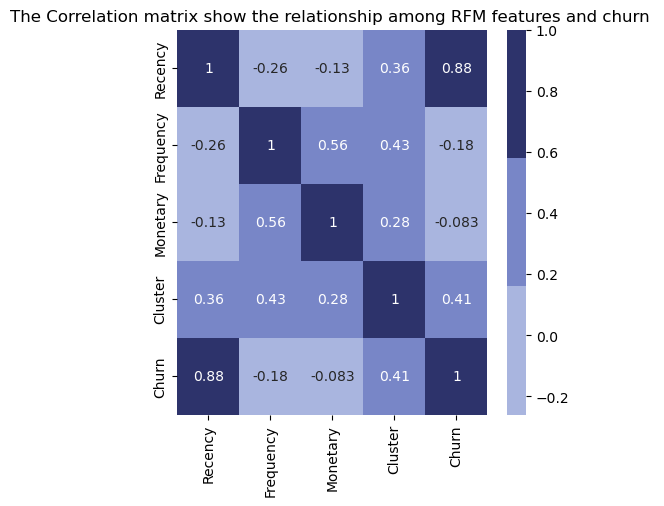

In [97]:
plt.figure(figsize=(5,5))
sns.heatmap(rfm.corr(), annot=True, cmap= colorscale1)
plt.title('The Correlation matrix show the relationship among RFM features and churn ')
plt.show()


In [99]:
df_2.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled,IsCanceled,InvoiceNo_clean,TotalPrice,StockCode_Type
0,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346.0,United Kingdom,74215,False,541431,0.0,Regular
1,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,2011-01-18 10:17:00,1.04,12346.0,United Kingdom,-74215,True,541433,0.0,Regular
2,537626,85116,BLACK CANDELABRA T-LIGHT HOLDER,12,2010-12-07 14:57:00,2.10,12347.0,Iceland,0,False,537626,25.2,Regular
3,537626,22375,AIRLINE BAG VINTAGE JET SET BROWN,4,2010-12-07 14:57:00,4.25,12347.0,Iceland,0,False,537626,17.0,Regular
4,537626,71477,COLOUR GLASS. STAR T-LIGHT HOLDER,12,2010-12-07 14:57:00,3.25,12347.0,Iceland,0,False,537626,39.0,Regular


## Upload File df_2 for BI dashboard

In [100]:
df_2.to_csv("dataset/processed_data", index=False)
